DataBase Description:
The Complete Journey
Source: Dunnhumby
Description:
completejourney provides access to data sets characterizing household level transactions over one year from a group of 2,469 households who are frequent shoppers at a grocery store. It contains all of each household’s purchases, not just those from a limited number of categories. For certain households, demographic information as well as direct marketing contact history are captured.
There are eight built-in data sets available in this package. The data sets include:

- campaigns: campaigns received by each household
- campaign_descriptions: campaign metadata (length of time active)
- coupons: coupon metadata (UPC code, campaign, etc.)
- coupon_redemptions: coupon redemptions (household, day, UPC code, campaign)
- demographics: household demographic data (age, income, family size, etc.)
- products: product metadata (brand, description, etc.)
- promotions_sample: a sampling of the product placement in mailers and in stores corresponding to advertising campaigns
- transactions_sample: a sampling of the products purchased by households


## Setup & Imports


In [1]:
# Import necessary libraries
import plotly
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# Set Parameters
warnings.filterwarnings("ignore")
dataset_folder = "../Data/"
export_folder = "../Export/"
np.random.seed(42)  # Setup numpy seed for reproducibility

In [3]:
# Load the dataset's csv files
with tqdm(total=4) as pbar:
    df_product = pd.read_csv(dataset_folder + "product.csv")
    pbar.update(1)
    df_demographic = pd.read_csv(dataset_folder + "hh_demographic.csv")
    pbar.update(1)
    df_trnsct = pd.read_csv(dataset_folder + "transaction_data.csv")
    pbar.update(1)
    df_campaign = pd.read_csv(dataset_folder + "campaign_desc.csv")
    pbar.update(1)

# Print loaded datasets file names
print(
    f"Loaded 4 datasets: product.csv, hh_demographic.csv, transaction_data.csv, campaign_desc.csv"
)

100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

Loaded 4 datasets: product.csv, hh_demographic.csv, transaction_data.csv, campaign_desc.csv


---

# Traitement des Valeurs Manquantes


In this part we will process the missing values

## 1. Demographic Dataframe

#### a. General Analysis

In [4]:
df_demographic.head(5)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [5]:
df_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AGE_DESC             801 non-null    object
 1   MARITAL_STATUS_CODE  801 non-null    object
 2   INCOME_DESC          801 non-null    object
 3   HOMEOWNER_DESC       801 non-null    object
 4   HH_COMP_DESC         801 non-null    object
 5   HOUSEHOLD_SIZE_DESC  801 non-null    object
 6   KID_CATEGORY_DESC    801 non-null    object
 7   household_key        801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


We can see that the columns ['HOMEOWNER_DESC', 'HH_COMP_DESC', 'KID_CATEGORY_DESC','MARITAL_STATUS'] all have missing values as Unknwown or None/Unknown

##### b. KID_CATEGORY_DESC

In [6]:
df_demographic["KID_CATEGORY_DESC"].value_counts()

KID_CATEGORY_DESC
None/Unknown    558
1               114
3+               69
2                60
Name: count, dtype: int64

In [7]:
# Get the 'HH_COMP_DESC' values where 'KID_CATEGORY_DESC' is 'None/Unknown' in the df_demographic DataFrame
# Then, count the unique values of 'HH_COMP_DESC'
df_demographic[df_demographic["KID_CATEGORY_DESC"] == "None/Unknown"][
    "HH_COMP_DESC"
].value_counts()

HH_COMP_DESC
2 Adults No Kids    255
Single Female       144
Single Male          95
Unknown              64
Name: count, dtype: int64

We can see that the majority of KIDS marked as None/Unknown are from adults with no kids ['2 Adults No Kids', 'Single Female', 'Single Male']. <br/>
We can set those values to 0.


In [8]:
# Update the 'KID_CATEGORY_DESC' column in the df_demographic DataFrame
df_demographic["KID_CATEGORY_DESC"] = np.where(
    # Condition: If 'KID_CATEGORY_DESC' is 'None/Unknown' AND 'HH_COMP_DESC' is not 'Unknown'
    (df_demographic["KID_CATEGORY_DESC"] == "None/Unknown")
    & (~(df_demographic["HH_COMP_DESC"] == "Unknown")),
    0,  # If condition is True, set value to 0
    df_demographic[
        "KID_CATEGORY_DESC"
    ],  # If condition is False, keep the original value
)
df_demographic["KID_CATEGORY_DESC"].value_counts()

KID_CATEGORY_DESC
0               494
1               114
3+               69
None/Unknown     64
2                60
Name: count, dtype: int64

In [9]:
# Filter the df_demographic DataFrame to only include rows where 'KID_CATEGORY_DESC' is 'None/Unknown'
# Then, select the 'HOUSEHOLD_SIZE_DESC', 'HH_COMP_DESC', and 'MARITAL_STATUS_CODE' columns from this filtered DataFrame
# Finally, count the unique combinations of these three columns
df_demographic[df_demographic["KID_CATEGORY_DESC"] == "None/Unknown"][
    ["HOUSEHOLD_SIZE_DESC", "HH_COMP_DESC", "MARITAL_STATUS_CODE"]
].value_counts()

HOUSEHOLD_SIZE_DESC  HH_COMP_DESC  MARITAL_STATUS_CODE
1                    Unknown       U                      59
2                    Unknown       A                       3
1                    Unknown       B                       2
Name: count, dtype: int64

We can see that the remaining Unknown kids can be deduced from the household size as Household Size of 1 has no kids. Both household types are of an unknown composition. The households having 2 persons are married. We can assume that therefore, they have no kids.

In [10]:
df_demographic["KID_CATEGORY_DESC"].replace(
    "None/Unknown", 0, inplace=True
)  # Replace 'None/Unknown' with 0
df_demographic["KID_CATEGORY_DESC"].value_counts()

KID_CATEGORY_DESC
0     558
1     114
3+     69
2      60
Name: count, dtype: int64

In [11]:
# Replace the 3+ values in the 'KID_CATEGORY_DESC' column with 3 to convert the column to integers.
df_demographic["KID_CATEGORY_DESC"] = (
    df_demographic["KID_CATEGORY_DESC"].replace("3+", 3).astype(int)
)
df_demographic["KID_CATEGORY_DESC"].value_counts()

KID_CATEGORY_DESC
0    558
1    114
3     69
2     60
Name: count, dtype: int64

#### c. HH_COMP_DESC

In [12]:
df_demographic["HH_COMP_DESC"].value_counts()

HH_COMP_DESC
2 Adults No Kids    255
2 Adults Kids       187
Single Female       144
Single Male          95
Unknown              73
1 Adult Kids         47
Name: count, dtype: int64

In [13]:
# Filter the df_demographic DataFrame to only include rows where 'HH_COMP_DESC' is 'Unknown'
# Then, select the 'HOUSEHOLD_SIZE_DESC' and 'KID_CATEGORY_DESC' columns from this filtered DataFrame
# Finally, count the unique combinations of these two columns.
df_demographic[df_demographic["HH_COMP_DESC"] == "Unknown"][
    ["HOUSEHOLD_SIZE_DESC", "KID_CATEGORY_DESC"]
].value_counts()

HOUSEHOLD_SIZE_DESC  KID_CATEGORY_DESC
1                    0                    61
3                    1                     5
2                    0                     3
5+                   3                     3
2                    1                     1
Name: count, dtype: int64

We can fill the Houses with 1 person and no kids as a new value: '1 Adult No Kids'

In [14]:
# Update the 'HH_COMP_DESC' column in the df_demographic DataFrame
df_demographic["HH_COMP_DESC"] = np.where(
    # Condition: If 'HH_COMP_DESC' is 'Unknown' AND 'HOUSEHOLD_SIZE_DESC' is '1'
    (df_demographic["HH_COMP_DESC"] == "Unknown")
    & (df_demographic["HOUSEHOLD_SIZE_DESC"] == "1"),
    "1 Adult No Kids",  # If condition is True, set value to '1 Adult No Kids'
    df_demographic["HH_COMP_DESC"],  # If condition is False, keep the original value
)
df_demographic["HH_COMP_DESC"].value_counts()

HH_COMP_DESC
2 Adults No Kids    255
2 Adults Kids       187
Single Female       144
Single Male          95
1 Adult No Kids      61
1 Adult Kids         47
Unknown              12
Name: count, dtype: int64

In [15]:
df_demographic[df_demographic["HH_COMP_DESC"] == "Unknown"]

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
87,35-44,A,Under 15K,Renter,Unknown,3,1,249
140,25-34,A,25-34K,Unknown,Unknown,2,0,404
194,45-54,A,125-149K,Homeowner,Unknown,3,1,582
218,55-64,A,50-74K,Homeowner,Unknown,2,0,660
341,35-44,A,35-49K,Unknown,Unknown,5+,3,1012
375,45-54,U,50-74K,Unknown,Unknown,2,1,1135
382,45-54,A,35-49K,Homeowner,Unknown,2,0,1154
505,45-54,A,75-99K,Homeowner,Unknown,3,1,1563
579,45-54,U,125-149K,Homeowner,Unknown,5+,3,1834
584,45-54,A,75-99K,Homeowner,Unknown,3,1,1848


We can see that we can deduce the household composition from the diffrence between the Household size and the number of kids.

In [16]:
# First we need to convert the column to int and replace the '5+' values with 5 to do so.
df_demographic["HOUSEHOLD_SIZE_DESC"] = (
    df_demographic["HOUSEHOLD_SIZE_DESC"].replace("5+", 5).astype(int)
)
df_demographic["HH_COMP_DESC"].value_counts()

HH_COMP_DESC
2 Adults No Kids    255
2 Adults Kids       187
Single Female       144
Single Male          95
1 Adult No Kids      61
1 Adult Kids         47
Unknown              12
Name: count, dtype: int64

In [17]:
# Define the condition lists
unknown_cond = df_demographic["HH_COMP_DESC"] == "Unknown"
conditions = [
    (
        unknown_cond
        & (
            df_demographic["HOUSEHOLD_SIZE_DESC"] - df_demographic["KID_CATEGORY_DESC"]
            == 2
        )
        & (df_demographic["KID_CATEGORY_DESC"] == 0)
    ),
    (
        unknown_cond
        & (
            df_demographic["HOUSEHOLD_SIZE_DESC"] - df_demographic["KID_CATEGORY_DESC"]
            == 2
        )
        & (df_demographic["KID_CATEGORY_DESC"] != 0)
    ),
    (
        unknown_cond
        & (
            df_demographic["HOUSEHOLD_SIZE_DESC"] - df_demographic["KID_CATEGORY_DESC"]
            == 1
        )
        & (df_demographic["KID_CATEGORY_DESC"] == 0)
    ),
    (
        unknown_cond
        & (
            df_demographic["HOUSEHOLD_SIZE_DESC"] - df_demographic["KID_CATEGORY_DESC"]
            == 1
        )
        & (df_demographic["KID_CATEGORY_DESC"] != 0)
    ),
]

# Define the choice list
choices = ["2 Adults No Kids", "2 Adults Kids", "1 Adult No Kids", "1 Adult Kids"]

# Create a new column with the new values
df_demographic["HH_COMP_DESC"] = np.select(
    conditions, choices, default=df_demographic["HH_COMP_DESC"]
)

df_demographic["HH_COMP_DESC"].value_counts()

HH_COMP_DESC
2 Adults No Kids    258
2 Adults Kids       195
Single Female       144
Single Male          95
1 Adult No Kids      61
1 Adult Kids         48
Name: count, dtype: int64

#### d. HOMEOWNER_DESC

In [18]:
df_demographic["HOMEOWNER_DESC"].value_counts()

HOMEOWNER_DESC
Homeowner          504
Unknown            233
Renter              42
Probable Renter     11
Probable Owner      11
Name: count, dtype: int64

In [19]:
# Replace 'Unknown' values in the 'HOMEOWNER_DESC' column of the df_demographic DataFrame with NA (missing) values
df_demographic["HOMEOWNER_DESC"].replace("Unknown", pd.NA, inplace=True)

We will fill the Homeowner description column with the same distribution as the non missing values

In [20]:
# Create a dictionnary with the ratio of each non NA value in the column
homeowner_probability = (
    df_demographic["HOMEOWNER_DESC"].value_counts(normalize=True).to_dict()
)
homeowner_probability

{'Homeowner': 0.8873239436619719,
 'Renter': 0.07394366197183098,
 'Probable Renter': 0.01936619718309859,
 'Probable Owner': 0.01936619718309859}

In [21]:
# Fill the NA values with np.random while passing the existing values ratio as probability to the random function
df_demographic["HOMEOWNER_DESC"] = df_demographic["HOMEOWNER_DESC"].fillna(
    np.random.choice(
        list(homeowner_probability.keys()), p=list(homeowner_probability.values())
    )
)
df_demographic["HOMEOWNER_DESC"].value_counts(normalize=True)

HOMEOWNER_DESC
Homeowner          0.920100
Renter             0.052434
Probable Renter    0.013733
Probable Owner     0.013733
Name: proportion, dtype: float64

#### e. MARITAL_STATUS_CODE

In [22]:
df_demographic["MARITAL_STATUS_CODE"].value_counts()

MARITAL_STATUS_CODE
U    344
A    340
B    117
Name: count, dtype: int64

In [23]:
# We can probably infer the marital status from the 'HH_COMP_DESC' column
df_demographic[["HH_COMP_DESC", "MARITAL_STATUS_CODE"]].value_counts().sort_index()

HH_COMP_DESC      MARITAL_STATUS_CODE
1 Adult Kids      A                       16
                  B                       14
                  U                       18
1 Adult No Kids   B                        2
                  U                       59
2 Adults Kids     A                      141
                  B                        9
                  U                       45
2 Adults No Kids  A                      138
                  B                       28
                  U                       92
Single Female     A                       33
                  B                       39
                  U                       72
Single Male       A                       12
                  B                       25
                  U                       58
Name: count, dtype: int64

In [24]:
# Replace the 'U' values in the 'MARITAL_STATUS_CODE' column of the df_demographic DataFrame with NA (missing) values
# And then see the distribution between 'A': Married & 'B': Single for each Household composition
marital_proba = (
    df_demographic[["HH_COMP_DESC", "MARITAL_STATUS_CODE"]]
    .replace("U", np.NaN)
    .value_counts()
    .sort_index()
)
marital_proba

HH_COMP_DESC      MARITAL_STATUS_CODE
1 Adult Kids      A                       16
                  B                       14
1 Adult No Kids   B                        2
2 Adults Kids     A                      141
                  B                        9
2 Adults No Kids  A                      138
                  B                       28
Single Female     A                       33
                  B                       39
Single Male       A                       12
                  B                       25
Name: count, dtype: int64

In [25]:
# Extract the ratio of each value ['A','B'] for each 'HH_COMP_DESC' value and use it to fill the missing values according to that ratio

# For each unique value in the 'HH_COMP_DESC' column (represented by 'comp_desc')
for comp_desc in marital_proba.index.levels[0]:
    # Calculate the proportion of each 'MARITAL_STATUS_CODE' value within the current 'HH_COMP_DESC' group
    marital_proba[comp_desc] = marital_proba[comp_desc] / marital_proba[comp_desc].sum()

    comp_desc_proba = marital_proba[comp_desc].to_dict()
    print(f"{comp_desc}: {comp_desc_proba}")

    # Update the 'MARITAL_STATUS_CODE' column in the df_demographic DataFrame
    df_demographic["MARITAL_STATUS_CODE"] = np.where(
        # Condition: If 'MARITAL_STATUS_CODE' is 'U' AND 'HH_COMP_DESC' is the current 'comp_desc' value
        (df_demographic["MARITAL_STATUS_CODE"] == "U")
        & (df_demographic["HH_COMP_DESC"] == comp_desc),
        # If condition is True, randomly select a 'MARITAL_STATUS_CODE' value based on the calculated proportions
        np.random.choice(
            list(comp_desc_proba.keys()), p=list(comp_desc_proba.values())
        ),
        # If condition is False, keep the original value
        df_demographic["MARITAL_STATUS_CODE"],
    )

1 Adult Kids: {'A': 0.5333333333333333, 'B': 0.4666666666666667}
1 Adult No Kids: {'B': 1.0}
2 Adults Kids: {'A': 0.94, 'B': 0.06}
2 Adults No Kids: {'A': 0.8313253012048193, 'B': 0.1686746987951807}
Single Female: {'A': 0.4583333333333333, 'B': 0.5416666666666666}
Single Male: {'A': 0.32432432432432434, 'B': 0.6756756756756757}


In [26]:
df_demographic["MARITAL_STATUS_CODE"].value_counts(normalize=True)

MARITAL_STATUS_CODE
A    0.757803
B    0.242197
Name: proportion, dtype: float64

All Missing values in the dataframe are now resolved.

In [27]:
df_demographic

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,0,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,0,7
2,25-34,A,25-34K,Homeowner,2 Adults Kids,3,1,8
3,25-34,A,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,0,16
...,...,...,...,...,...,...,...,...
796,35-44,A,50-74K,Homeowner,2 Adults No Kids,2,0,2494
797,45-54,A,75-99K,Homeowner,2 Adults Kids,3,1,2496
798,45-54,A,35-49K,Homeowner,Single Male,1,0,2497
799,25-34,A,50-74K,Homeowner,2 Adults No Kids,2,0,2498


---

## 2. Transaction DataFrame

In [28]:
df_trnsct.head(5)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [29]:
df_trnsct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   household_key      int64  
 1   BASKET_ID          int64  
 2   DAY                int64  
 3   PRODUCT_ID         int64  
 4   QUANTITY           int64  
 5   SALES_VALUE        float64
 6   STORE_ID           int64  
 7   RETAIL_DISC        float64
 8   TRANS_TIME         int64  
 9   WEEK_NO            int64  
 10  COUPON_DISC        float64
 11  COUPON_MATCH_DISC  float64
dtypes: float64(4), int64(8)
memory usage: 237.6 MB


In [30]:
df_trnsct.isna().sum()

household_key        0
BASKET_ID            0
DAY                  0
PRODUCT_ID           0
QUANTITY             0
SALES_VALUE          0
STORE_ID             0
RETAIL_DISC          0
TRANS_TIME           0
WEEK_NO              0
COUPON_DISC          0
COUPON_MATCH_DISC    0
dtype: int64

---

## 3. Products Dataframe

In [31]:
df_product.head(5)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [32]:
df_product["CURR_SIZE_OF_PRODUCT"].value_counts()

CURR_SIZE_OF_PRODUCT
              30607
16 OZ          3924
12 OZ          3473
8 OZ           2363
6 OZ           1697
              ...  
4/3.75OZ          1
24 OZ/ CAN        1
997874  PK        1
19.3 OZ           1
2 LTR PET         1
Name: count, Length: 4345, dtype: int64

In [33]:
df_product["DEPARTMENT"].value_counts()

DEPARTMENT
GROCERY            39021
DRUG GM            31529
PRODUCE             3118
COSMETICS           3011
NUTRITION           2914
MEAT                2544
MEAT-PCKGD          2427
DELI                2354
PASTRY              2149
FLORAL               938
SEAFOOD-PCKGD        563
MISC. TRANS.         490
SPIRITS              377
SEAFOOD              369
GARDEN CENTER        128
RESTAURANT           102
MISC SALES TRAN       88
SALAD BAR             48
COUP/STR & MFG        39
TRAVEL & LEISUR       28
FROZEN GROCERY        23
KIOSK-GAS             16
                      15
CHEF SHOPPE           14
RX                     9
CNTRL/STORE SUP        4
DAIRY DELI             3
TOYS                   3
POSTAL CENTER          3
GM MERCH EXP           3
VIDEO RENTAL           3
AUTOMOTIVE             2
PHOTO                  2
VIDEO                  2
PROD-WHS SALES         2
DELI/SNACK BAR         2
CHARITABLE CONT        2
GRO BAKERY             2
PORK                   1
HBC           

In [34]:
df_product.drop(
    columns=[
        "COMMODITY_DESC",
        "SUB_COMMODITY_DESC",
        "CURR_SIZE_OF_PRODUCT",
    ],
    inplace=True,
)

In [35]:
df_product

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND
0,25671,2,GROCERY,National
1,26081,2,MISC. TRANS.,National
2,26093,69,PASTRY,Private
3,26190,69,GROCERY,Private
4,26355,69,GROCERY,Private
...,...,...,...,...
92348,18293142,6384,DRUG GM,National
92349,18293439,6393,DRUG GM,National
92350,18293696,6406,DRUG GM,National
92351,18294080,6442,DRUG GM,National


---

## 4.Campaigns Dataframe

In [36]:
df_campaign.head(5)

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [37]:
df_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DESCRIPTION  30 non-null     object
 1   CAMPAIGN     30 non-null     int64 
 2   START_DAY    30 non-null     int64 
 3   END_DAY      30 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ KB


---

# Other Data Processing

In [38]:
df_demographic["INCOME_DESC"].value_counts()

INCOME_DESC
50-74K       192
35-49K       172
75-99K        96
25-34K        77
15-24K        74
Under 15K     61
125-149K      38
100-124K      34
150-174K      30
250K+         11
175-199K      11
200-249K       5
Name: count, dtype: int64

In [39]:
new_income_list = {
    "<25K": ["Under 15K", "15-24K"],
    "25-49K": ["25-34K", "35-49K"],
    "50-99K": ["50-74K", "75-99K"],
    "100-149K": ["100-124K", "125-149K"],
    "150K+": ["150-174K", "175-199K", "200-249K", "250K+"],
}
df_demographic["INCOME_DESC_REDUCED"] = np.select(
    [df_demographic["INCOME_DESC"].isin(v) for v in new_income_list.values()],
    list(new_income_list.keys()),
)
df_demographic["INCOME_DESC_REDUCED"].value_counts()

INCOME_DESC_REDUCED
50-99K      288
25-49K      249
<25K        135
100-149K     72
150K+        57
Name: count, dtype: int64

In [40]:
df_demographic["AGE_DESC"].value_counts()

AGE_DESC
45-54    288
35-44    194
25-34    142
65+       72
55-64     59
19-24     46
Name: count, dtype: int64

In [41]:
new_age_list = {
    "19-34": ["19-24", "25-34"],
    "35-54": ["35-44", "45-54"],
    "55-65+": ["55-64", "65+"],
}

df_demographic["AGE_DESC_REDUCED"] = np.select(
    [df_demographic["AGE_DESC"].isin(v) for v in new_age_list.values()],
    list(new_age_list.keys()),
    default=df_demographic["AGE_DESC"],
)
df_demographic["AGE_DESC_REDUCED"].value_counts()

AGE_DESC_REDUCED
35-54     482
19-34     188
55-65+    131
Name: count, dtype: int64

In [42]:
df_demographic["HH_COMP_DESC"].replace("Single Female", "1 Adult No Kids", inplace=True)
df_demographic["HH_COMP_DESC"].replace("Single Male", "1 Adult No Kids", inplace=True)
df_demographic["HH_COMP_DESC"].value_counts()

HH_COMP_DESC
1 Adult No Kids     300
2 Adults No Kids    258
2 Adults Kids       195
1 Adult Kids         48
Name: count, dtype: int64

In [43]:
#df_trnsct['TRANS_TIME'] = pd.to_datetime(df_trnsct['TRANS_TIME'].astype("str").str.zfill(4).apply(lambda x : f"{x[:2]}:{x[2:]}")).dt.time
df_trnsct['TRANS_TIME']

0          1631
1          1631
2          1631
3          1631
4          1631
           ... 
2595727    1520
2595728    1520
2595729    1520
2595730    1520
2595731    1520
Name: TRANS_TIME, Length: 2595732, dtype: int64

In [44]:
# Define the reference start date
reference_date = pd.Timestamp("01-01-12")

# Add days to the reference date to calculate the actual date
df_trnsct["TRANS_DATE"] = reference_date + pd.to_timedelta(df_trnsct["DAY"], unit="D")
df_trnsct.drop(columns=["DAY"], inplace=True)

df_trnsct["TRANS_DATE"]

0         2012-01-02
1         2012-01-02
2         2012-01-02
3         2012-01-02
4         2012-01-02
             ...    
2595727   2013-12-12
2595728   2013-12-12
2595729   2013-12-12
2595730   2013-12-12
2595731   2013-12-12
Name: TRANS_DATE, Length: 2595732, dtype: datetime64[ns]

In [45]:
df_campaign["START_MONTH"] = abs(df_campaign["START_DAY"] / 28)
df_campaign["END_MONTH"] = abs(df_campaign["END_DAY"] / 28)
df_campaign.drop(columns=["START_DAY", "END_DAY"], inplace=True)
df_campaign.head(3)

,DESCRIPTION,CAMPAIGN,START_MONTH,END_MONTH
0,TypeB,24,23.535714,25.678571
1,TypeC,15,19.535714,25.285714
2,TypeB,25,23.535714,24.678571


---

# New Variables Creation

In this section we will create new variables/metrics for a better data analysis

### Number Of Products Per Transaction

We create a new series with the Number of Products Sold Per Trnasaction Per Store

In [46]:
df_trnsct.groupby("BASKET_ID").aggregate(
    {"PRODUCT_ID": "count", "STORE_ID": "first"}
).rename({"PRODUCT_ID": "NB_PROD_SOLD/TRNSCT"}, axis=1).set_index("STORE_ID").groupby(
    "STORE_ID"
).mean().round().sort_values(
    "NB_PROD_SOLD/TRNSCT", ascending=False
)

,NB_PROD_SOLD/TRNSCT
STORE_ID,
569,62.0
278,47.0
3525,47.0
3483,39.0
107,35.0
...,...
274,1.0
2996,1.0
584,1.0


### Create New variable: Date of first purchase to track customer acquisition

In [47]:
df_trnsct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   household_key      int64         
 1   BASKET_ID          int64         
 2   PRODUCT_ID         int64         
 3   QUANTITY           int64         
 4   SALES_VALUE        float64       
 5   STORE_ID           int64         
 6   RETAIL_DISC        float64       
 7   TRANS_TIME         int64         
 8   WEEK_NO            int64         
 9   COUPON_DISC        float64       
 10  COUPON_MATCH_DISC  float64       
 11  TRANS_DATE         datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(7)
memory usage: 237.6 MB


In [48]:
customer_first_date = (
    df_trnsct[["household_key", "TRANS_DATE"]]
    .groupby(["household_key", "TRANS_DATE"])
    .value_counts()
)
customer_first_date = customer_first_date.reset_index()
customer_first_date.drop(columns=["count"], inplace=True)
customer_first_date = customer_first_date.groupby("household_key").min()
customer_first_date = customer_first_date.rename(
    columns={"DAY": "Day_of_first_purchase", "index": "household_key"}
)
customer_first_date

,TRANS_DATE
household_key,
1,2012-02-21
2,2012-04-13
3,2012-04-23
4,2012-04-14
5,2012-03-26
...,...
2496,2012-04-27
2497,2012-03-19
2498,2012-04-15


In [49]:
df_customer_acquisition = (
    customer_first_date.value_counts()
    .reset_index()
    .rename(columns={"TRANS_DATE": "Date_of_first_purchase", "count": "Number_of_households"})
    .sort_values("Date_of_first_purchase")
)
df_customer_acquisition

,Date_of_first_purchase,Number_of_households
97,2012-01-02,15
115,2012-01-03,10
20,2012-01-04,26
41,2012-01-05,23
102,2012-01-06,14
...,...,...
123,2012-08-05,1
124,2012-10-04,1
125,2013-03-09,1
126,2013-09-05,1


In [66]:
df_customer_acquisition.set_index("Date_of_first_purchase").reindex(pd.date_range("2012-01-01", "2013-12-31", freq="D")).fillna(0).reset_index().rename(columns={"index": "Date_of_first_purchase"})

,Date_of_first_purchase,Number_of_households
0,2012-01-01,0.0
1,2012-01-02,15.0
2,2012-01-03,10.0
3,2012-01-04,26.0
4,2012-01-05,23.0
...,...,...
726,2013-12-27,0.0
727,2013-12-28,0.0
728,2013-12-29,0.0
729,2013-12-30,0.0


## Chiffre d'affaire

In [50]:
daily_sales = df_trnsct[["SALES_VALUE"]].groupby(df_trnsct["TRANS_DATE"]).sum().reset_index()
daily_sales_avg_month = (
    daily_sales.groupby(daily_sales["TRANS_DATE"].dt.to_period("M"))
    .mean()
    .drop("TRANS_DATE", axis=1)
    .reset_index()
)
daily_sales_avg_month

,TRANS_DATE,SALES_VALUE
0,2012-01,1850.249333
1,2012-02,3960.548621
2,2012-03,7129.661290
3,2012-04,10596.928667
4,2012-05,11413.280645
5,2012-06,11888.529667
6,2012-07,11570.382903
7,2012-08,11736.498710
8,2012-09,12338.359667
9,2012-10,12183.776129


### Age & Income Mean demographic

In [51]:
df_demographic["MEAN_AGE"]=df_demographic["AGE_DESC"].replace("65+","65").str.extract(r'(\d+)-(\d+)|(\d+)').astype(float).mean(axis=1)
df_demographic["MEAN_AGE"].value_counts()

MEAN_AGE
49.5    288
39.5    194
29.5    142
65.0     72
59.5     59
21.5     46
Name: count, dtype: int64

In [52]:
df_demographic["MEAN_INCOME"]=df_demographic["INCOME_DESC"].str.extract(r'(\d+)-(\d+)|(\d+)').astype(float).mean(axis=1)
df_demographic["MEAN_INCOME"]
df_demographic["MEAN_INCOME"].value_counts()

MEAN_INCOME
62.0     192
42.0     172
87.0      96
29.5      77
19.5      74
15.0      61
137.0     38
112.0     34
162.0     30
250.0     11
187.0     11
224.5      5
Name: count, dtype: int64

---

# Graphics Creation

## 1. Demographics

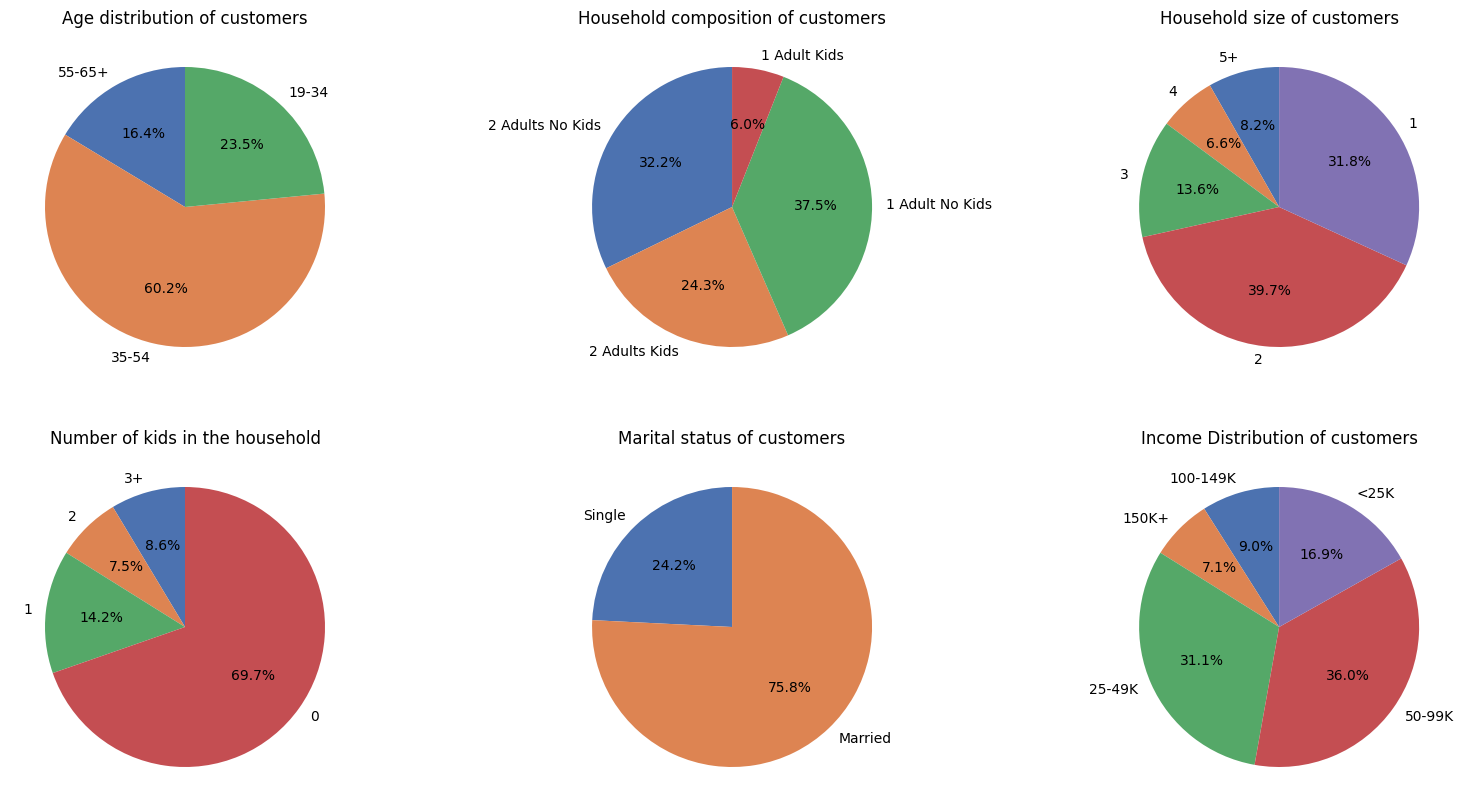

In [53]:
dmg_figs, dmg_axis = plt.subplots(2, 3, figsize=(20, 10))
color_palette = "deep"

dmg_axis[0, 0].pie(
    df_demographic["AGE_DESC_REDUCED"].value_counts().sort_index(ascending=False),
    labels=df_demographic["AGE_DESC_REDUCED"].value_counts().sort_index(ascending=False).index,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette(color_palette),
)
dmg_axis[0, 0].set_title("Age distribution of customers")

dmg_axis[0, 1].pie(
    df_demographic["HH_COMP_DESC"].value_counts().sort_index(ascending=False),
    labels=df_demographic["HH_COMP_DESC"]
    .value_counts()
    .sort_index(ascending=False)
    .index,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette(color_palette),
)
dmg_axis[0, 1].set_title("Household composition of customers")

dmg_axis[0, 2].pie(
    df_demographic["HOUSEHOLD_SIZE_DESC"].value_counts().sort_index(ascending=False),
    labels=df_demographic["HOUSEHOLD_SIZE_DESC"]
    .astype("str")
    .replace("5", "5+")
    .value_counts()
    .sort_index(ascending=False)
    .index,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette(color_palette),
)
dmg_axis[0, 2].set_title("Household size of customers")

dmg_axis[1, 0].pie(
    df_demographic["KID_CATEGORY_DESC"].value_counts().sort_index(ascending=False),
    labels=df_demographic["KID_CATEGORY_DESC"]
    .astype("str")
    .replace("3", "3+")
    .value_counts()
    .sort_index(ascending=False)
    .index,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette(color_palette),
)
dmg_axis[1, 0].set_title("Number of kids in the household")

dmg_axis[1, 1].pie(
    df_demographic["MARITAL_STATUS_CODE"]
    .replace({"A": "Married", "B": "Single"})
    .value_counts()
    .sort_index(ascending=False),
    labels=df_demographic["MARITAL_STATUS_CODE"]
    .replace({"A": "Married", "B": "Single"})
    .value_counts()
    .sort_index(ascending=False)
    .index,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette(color_palette),
)
dmg_axis[1, 1].set_title("Marital status of customers")

dmg_axis[1, 2].pie(
    df_demographic["INCOME_DESC_REDUCED"].value_counts().sort_index(ascending=True),
    labels=df_demographic["INCOME_DESC_REDUCED"]
    .value_counts()
    .sort_index(ascending=True)
    .index,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette(color_palette),
)
dmg_axis[1, 2].set_title("Income Distribution of customers")


plt.show()

## 2. Product Department Wordcloud

In [54]:
df_product["DEPARTMENT"].nunique()

44

In [55]:
# Preprocess the text to make it all lower case and remove leading/trailing spaces
frequence_produits = df_trnsct.merge(df_product, how="left", on="PRODUCT_ID")[
    "DEPARTMENT"
]
frequence_produits = " ".join(v for v in frequence_produits)

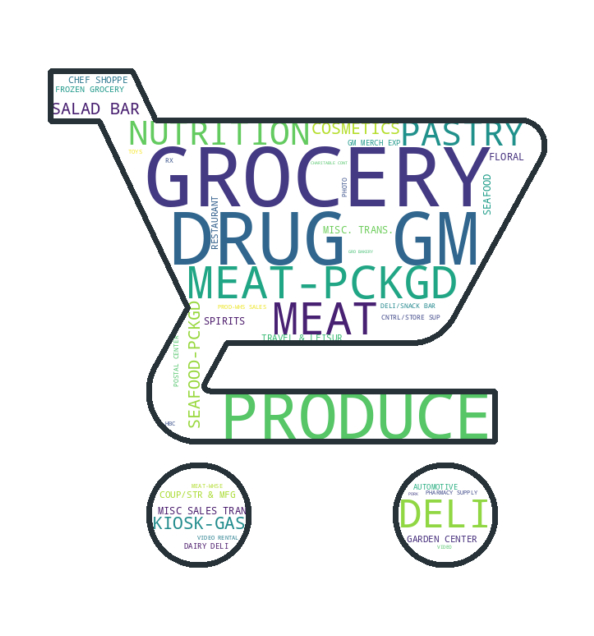

In [56]:
# Preprocess the text to make it all lower case and remove leading/trailing spaces
frequence_produits = np.log(
    df_trnsct.merge(df_product, how="left", on="PRODUCT_ID")[
        "DEPARTMENT"
    ].value_counts()
)

mask = np.invert(np.array(Image.open("../Assets/WordCloudMask.png")))[::, 150:850]
wordcloud = WordCloud(
    background_color="white",
    mask=mask,
    contour_color="#263238",
    contour_width=10,
).generate_from_frequencies(frequence_produits)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Chiffre d'affaire 

In [57]:
daily_sales_avg_month.head(3)

,TRANS_DATE,SALES_VALUE
0,2012-01,1850.249333
1,2012-02,3960.548621
2,2012-03,7129.661290


In [58]:
fig = px.line(
    x=daily_sales_avg_month["TRANS_DATE"].dt.month.astype("str"),
    y=daily_sales_avg_month["SALES_VALUE"],
    color=daily_sales_avg_month["TRANS_DATE"].dt.year,
    labels={
        "x": "Month",
        "y": "Average Daily Sales Value",
        "color": "Year",
    },
    markers=True,
)
fig.update_layout(
    title={
        "text": "Daily Sales Value Over Time by Year",
        "x": 0.5,
    },
    # Hide the grid lines
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
)

fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Year=2012<br>Month=%{x}<br>Average Daily Sales Value=%{y}<extra></extra>',
              'legendgroup': '2012',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': '2012',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
                         dtype=object),
              'xaxis': 'x',
              'y': array([ 1850.24933333,  3960.54862069,  7129.66129032, 10596.92866667,
                          11413.28064516, 11888.52966667, 11570.38290323, 11736.49870968,
                          12338.35966667, 12183.77612903, 12554.381     , 12230.70290323]),
              'yaxis': 'y'},
             {'hovertemplate': 'Year=2013<br>Month=%{x}<br>Average Daily Sales Value=%{y}<extra></extra>',
              'legendgroup': '2013',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': '2013',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
                         dtype=object),
              'xaxis': 'x',
              'y': array([12330.98967742, 12860.51285714, 12818.99225806, 12472.14966667,
                          12799.41903226, 12292.076     , 11987.01064516, 13168.9316129 ,
                          12880.62866667, 13352.26096774, 13552.22133333, 12113.99833333]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'Year'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Daily Sales Value Over Time by Year', 'x': 0.5},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'showgrid': False, 'title': {'text': 'Month'}},
               'yaxis': {'anchor': 'x',
                         'domain': [0.0, 1.0],
                         'showgrid': False,
                         'title': {'text': 'Average Daily Sales Value'}}}
})

## 4. New Customers

In [59]:
customer_first_date

,TRANS_DATE
household_key,
1,2012-02-21
2,2012-04-13
3,2012-04-23
4,2012-04-14
5,2012-03-26
...,...
2496,2012-04-27
2497,2012-03-19
2498,2012-04-15


In [60]:
fig = px.line(
    df_customer_acquisition,
    x="Date_of_first_purchase",
    y="Number_of_households",
    markers=True,
    labels={
        "Date_of_first_purchase": "Date of first purchase",
        "Number_of_households": "Number of households",
    },
)
fig.update_layout(
    title={"text": "Number of households acquired over time", "x": 0.5},
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
)
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Date of first purchase=%{x}<br>Number of households=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2012, 1, 2, 0, 0),
                          datetime.datetime(2012, 1, 3, 0, 0),
                          datetime.datetime(2012, 1, 4, 0, 0),
                          datetime.datetime(2012, 1, 5, 0, 0),
                          datetime.datetime(2012, 1, 6, 0, 0),
                          datetime.datetime(2012, 1, 7, 0, 0),
                          datetime.datetime(2012, 1, 8, 0, 0),
                          datetime.datetime(2012, 1, 9, 0, 0),
                          datetime.datetime(2012, 1, 10, 0, 0),
                          datetime.datetime(2012, 1, 11, 0, 0),
                          datetime.datetime(2012, 1, 12, 0, 0),
                          datetime.datetime(2012, 1, 13, 0, 0),
                          datetime.datetime(2012, 1, 14, 0, 0),
                          datetime.datetime(2012, 1, 15, 0, 0),
                          datetime.datetime(2012, 1, 16, 0, 0),
                          datetime.datetime(2012, 1, 17, 0, 0),
                          datetime.datetime(2012, 1, 18, 0, 0),
                          datetime.datetime(2012, 1, 19, 0, 0),
                          datetime.datetime(2012, 1, 20, 0, 0),
                          datetime.datetime(2012, 1, 21, 0, 0),
                          datetime.datetime(2012, 1, 22, 0, 0),
                          datetime.datetime(2012, 1, 23, 0, 0),
                          datetime.datetime(2012, 1, 24, 0, 0),
                          datetime.datetime(2012, 1, 25, 0, 0),
                          datetime.datetime(2012, 1, 26, 0, 0),
                          datetime.datetime(2012, 1, 27, 0, 0),
                          datetime.datetime(2012, 1, 28, 0, 0),
                          datetime.datetime(2012, 1, 29, 0, 0),
                          datetime.datetime(2012, 1, 30, 0, 0),
                          datetime.datetime(2012, 1, 31, 0, 0),
                          datetime.datetime(2012, 2, 1, 0, 0),
                          datetime.datetime(2012, 2, 2, 0, 0),
                          datetime.datetime(2012, 2, 3, 0, 0),
                          datetime.datetime(2012, 2, 4, 0, 0),
                          datetime.datetime(2012, 2, 5, 0, 0),
                          datetime.datetime(2012, 2, 6, 0, 0),
                          datetime.datetime(2012, 2, 7, 0, 0),
                          datetime.datetime(2012, 2, 8, 0, 0),
                          datetime.datetime(2012, 2, 9, 0, 0),
                          datetime.datetime(2012, 2, 10, 0, 0),
                          datetime.datetime(2012, 2, 11, 0, 0),
                          datetime.datetime(2012, 2, 12, 0, 0),
                          datetime.datetime(2012, 2, 13, 0, 0),
                          datetime.datetime(2012, 2, 14, 0, 0),
                          datetime.datetime(2012, 2, 15, 0, 0),
                          datetime.datetime(2012, 2, 16, 0, 0),
                          datetime.datetime(2012, 2, 17, 0, 0),
                          datetime.datetime(2012, 2, 18, 0, 0),
                          datetime.datetime(2012, 2, 19, 0, 0),
                          datetime.datetime(2012, 2, 20, 0, 0),
                          datetime.datetime(2012, 2, 21, 0, 0),
                          datetime.datetime(2012, 2, 22, 0, 0),
                          datetime.datetime(2012, 2, 23, 0, 0),
                          datetime.datetime(2012, 2, 24, 0, 0),
                          datetime.datetime(2012, 2, 25, 0, 0),
                          datetime.datetime(2012, 2, 26, 0, 0),
           

---

# Export

### Export the processed datasets to use in the streamlit dashboard

In [61]:
df_demographic.to_csv(export_folder + "hh_demographic_cleaned.csv",index=False)
print("Exported hh_demographic_cleaned.csv")

Exported hh_demographic_cleaned.csv


In [62]:
df_trnsct.to_csv(export_folder + "transaction_data_cleaned.csv",index=False)
print("Exported transaction_data_cleaned.csv")


KeyboardInterrupt



In [ ]:
daily_sales_avg_month.to_csv(export_folder + "daily_sales_avg_month.csv",index=False)
print("Exported daily_sales_avg_month.csv")

Exported daily_sales_avg_month.csv


In [ ]:
df_customer_acquisition.to_csv(export_folder + "customer_acquisition.csv",index=False)
print("Exported customer_acquisition.csv")

Exported customer_acquisition.csv
